Short tutorial inspired by http://katbailey.github.io/post/gaussian-processes-for-dummies/

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

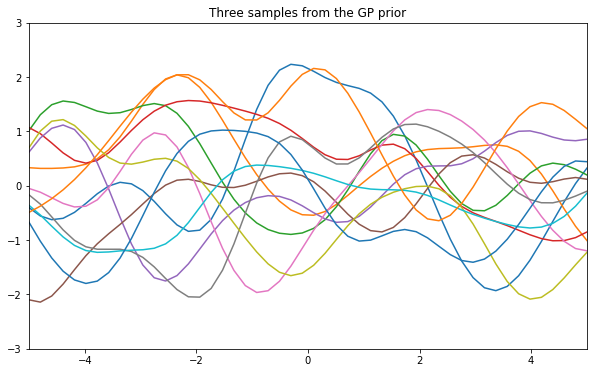

In [27]:
# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Compute the kernel
param = 1.0
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-12*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,12)))

#help(np.eye)

# Let's plot 3 sampled functions.

plt.figure(figsize=(10,6))
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP prior')
plt.show()